# SQL Analysis of the Dataset

The dataset has been loaded into an SQLite database to enable structured queries, aggregations, and view creation.  

In [1]:
import os
import sqlite3
import pandas as pd
from pathlib import Path

In [2]:
data_path = Path("../data_raw")

## 1. Connect to SQLite Database

Establish a connection to the SQLite database and define helper functions (`run_sql`, `exec_sql`)  
for running queries and executing SQL commands within Jupyter.


In [3]:
# Path to sqlite database file
DB_PATH = "../sql/data.sqlite"

# Create a connection
conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

cur.execute("PRAGMA foreign_keys = ON;")
conn.commit()

def run_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    #Run a SELECT query and return results as a Pandas DataFrame
    return pd.read_sql_query(query, conn, params=params)

def exec_sql(query: str, params: dict | None = None) -> None:
    #Execute a SQL command,  CREATE TABLE or INSERT
    cur.execute(query, params or ())
    conn.commit()



## 2. Load Data into SQLite

Raw CSV files are loaded into five core tables:  
- **customers**  
- **orders**  
- **items**
- **products**
- **product_category_translation**  

In [4]:
# Load raw CSV data into Pandas DataFrames
cust = pd.read_csv("../data_raw/olist_customers_dataset.csv")
orders = pd.read_csv("../data_raw/olist_orders_dataset.csv")
items = pd.read_csv("../data_raw/olist_order_items_dataset.csv")
prod = pd.read_csv("../data_raw/olist_products_dataset.csv")
trans = pd.read_csv("../data_raw/product_category_name_translation.csv")
                   
# Quick data integrity checks
assert cust["customer_id"].is_unique                     # each customer_id should be unique
assert orders["order_id"].is_unique                      # each order_id should be unique
assert items[["order_id","order_item_id"]].drop_duplicates().shape[0] == len(items)  # no duplicate order lines
assert orders["customer_id"].notna().all()               # every order must have a customer_id
assert items["order_id"].notna().all()                   # every order item must have an order_id

# Write DataFrames into SQLite tables
cust.to_sql("customers", conn, if_exists="replace", index=False)
orders.to_sql("orders", conn, if_exists="replace", index=False)
items.to_sql("order_items", conn, if_exists="replace", index=False)
prod.to_sql("products", conn, if_exists="replace", index=False)
trans.to_sql("product_category_translation", conn, if_exists="replace", index=False)

# Verify row counts in each table after load
print("Loaded rows:",
      run_sql("""
      SELECT 'customers' AS table_name, COUNT(*) AS rows FROM customers
      UNION ALL
      SELECT 'orders', COUNT(*) FROM orders
      UNION ALL
      SELECT 'order_items', COUNT(*) FROM order_items
      UNION ALL
      SELECT 'products', COUNT(*) FROM products;
      """))


Loaded rows:     table_name    rows
0    customers   99441
1       orders   99441
2  order_items  112650
3     products   32951


## 3.  Data Quality Check

- **Foreign key null checks** to ensure that every order links to a customer, and every order item links to an order.  
- **Duplicate key checks** (order_id + order_item_id) to detect accidental duplicate rows in the order_items table.  

In [5]:
#Null-FK
run_sql("SELECT COUNT(*) AS null_order_in_items FROM order_items WHERE order_id IS NULL;")

,null_order_in_items
0,0


In [6]:
run_sql("SELECT COUNT(*) AS null_customer_in_orders FROM orders WHERE customer_id IS NULL;")

,null_customer_in_orders
0,0


In [7]:
# Duplicate key (order_id + order_item_id)
run_sql("""
WITH d AS (
  SELECT order_id, order_item_id, COUNT(*) c
  FROM order_items
  GROUP BY order_id, order_item_id
  HAVING COUNT(*) > 1
)
SELECT COUNT(*) AS duplicate_order_lines FROM d;
""")

,duplicate_order_lines
0,0


## 4. Inspect Schema

Check the database schema and confirm that tables and columns were created correctly.  
`PRAGMA table_info` is used to list columns, data types, and constraints for each table.

In [8]:
# List tables
run_sql("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")

,name
0,customers
1,order_items
2,orders
3,product_category_translation
4,products


In [9]:
# Columns per table
run_sql("PRAGMA table_info(customers);")

,cid,name,type,notnull,dflt_value,pk
0,0,customer_id,TEXT,0,None,0
1,1,customer_unique_id,TEXT,0,None,0
2,2,customer_zip_code_prefix,INTEGER,0,None,0
3,3,customer_city,TEXT,0,None,0
4,4,customer_state,TEXT,0,None,0


In [10]:
run_sql("PRAGMA table_info(orders);")

,cid,name,type,notnull,dflt_value,pk
0,0,order_id,TEXT,0,None,0
1,1,customer_id,TEXT,0,None,0
2,2,order_status,TEXT,0,None,0
3,3,order_purchase_timestamp,TEXT,0,None,0
4,4,order_approved_at,TEXT,0,None,0
5,5,order_delivered_carrier_date,TEXT,0,None,0
6,6,order_delivered_customer_date,TEXT,0,None,0
7,7,order_estimated_delivery_date,TEXT,0,None,0


In [11]:
run_sql("PRAGMA table_info(order_items);")

,cid,name,type,notnull,dflt_value,pk
0,0,order_id,TEXT,0,None,0
1,1,order_item_id,INTEGER,0,None,0
2,2,product_id,TEXT,0,None,0
3,3,seller_id,TEXT,0,None,0
4,4,shipping_limit_date,TEXT,0,None,0
5,5,price,REAL,0,None,0
6,6,freight_value,REAL,0,None,0


In [12]:
run_sql("PRAGMA table_info(products);")

,cid,name,type,notnull,dflt_value,pk
0,0,product_id,TEXT,0,None,0
1,1,product_category_name,TEXT,0,None,0
2,2,product_name_lenght,REAL,0,None,0
3,3,product_description_lenght,REAL,0,None,0
4,4,product_photos_qty,REAL,0,None,0
5,5,product_weight_g,REAL,0,None,0
6,6,product_length_cm,REAL,0,None,0
7,7,product_height_cm,REAL,0,None,0
8,8,product_width_cm,REAL,0,None,0


In [13]:
run_sql("PRAGMA table_info(product_category_translation);")

,cid,name,type,notnull,dflt_value,pk
0,0,product_category_name,TEXT,0,None,0
1,1,product_category_name_english,TEXT,0,None,0


## 5. Create Indexes

In [14]:
cur.execute("CREATE INDEX IF NOT EXISTS idx_orders_customer_id ON orders(customer_id);"); conn.commit()
cur.execute("CREATE INDEX IF NOT EXISTS idx_items_order_id   ON order_items(order_id);"); conn.commit()
cur.execute("CREATE INDEX IF NOT EXISTS idx_items_product_id ON order_items(product_id);"); conn.commit()
cur.execute("CREATE INDEX IF NOT EXISTS idx_products_product_id ON products(product_id);");conn.commit()
cur.execute("CREATE INDEX IF NOT EXISTS idx_trans_pt ON product_category_translation(product_category_name);"); conn.commit()

## 6. Create KPI Views

Reusable SQL views are created to simplify analysis:  
- **v_sales_daily** → daily revenue and order counts  
- **v_customer_revenue** → total revenue and orders per customer  
- **v_sales_monthly** → Monthly revenue and order counts
- **v_top_products_per_customer** → top products for each customer based on total revenue


In [15]:
exec_sql("""CREATE VIEW IF NOT EXISTS v_sales_daily AS
SELECT 
  DATE(o.order_purchase_timestamp)          AS order_day,
  SUM(oi.price + oi.freight_value)          AS revenue,
  COUNT(DISTINCT o.order_id)                AS orders
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
WHERE o.order_status IN ('delivered','invoiced','shipped')
GROUP BY DATE(o.order_purchase_timestamp);""")

In [16]:
run_sql("SELECT * FROM v_sales_daily ORDER BY order_day LIMIT 10;")

,order_day,revenue,orders
0,2016-09-04,136.23,1
1,2016-09-15,143.46,1
2,2016-10-03,559.53,7
3,2016-10-04,10900.95,58
4,2016-10-05,7785.14,38
5,2016-10-06,7326.68,46
6,2016-10-07,7601.29,43
7,2016-10-08,9226.19,38
8,2016-10-09,3048.73,21
9,2016-10-10,4493.39,37


In [17]:
exec_sql("""
CREATE VIEW IF NOT EXISTS v_customer_revenue AS 
SELECT
    o.customer_id,
    SUM(oi.price + oi.freight_value) AS revenue,
    COUNT(DISTINCT o.order_id)       AS orders
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY o.customer_id;
""")


In [18]:
run_sql("SELECT * FROM v_customer_revenue ORDER BY revenue DESC LIMIT 10;")

,customer_id,revenue,orders
0,1617b1357756262bfa56ab541c47bc16,13664.08,1
1,ec5b2ba62e574342386871631fafd3fc,7274.88,1
2,c6e2731c5b391845f6800c97401a43a9,6929.31,1
3,f48d464a0baaea338cb25f816991ab1f,6922.21,1
4,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,1
5,05455dfa7cd02f13d132aa7a6a9729c6,6081.54,1
6,df55c14d1476a9a3467f131269c2477f,4950.34,1
7,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,1
8,24bbf5fd2f2e1b359ee7de94defc4a15,4764.34,1
9,3d979689f636322c62418b6346b1c6d2,4681.78,1


In [19]:
exec_sql("""
CREATE VIEW IF NOT EXISTS v_sales_monthly AS
SELECT 
  strftime('%Y-%m', o.order_purchase_timestamp) AS ym,
  COUNT(DISTINCT o.order_id) AS orders,
  SUM(oi.price + oi.freight_value) AS revenue
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY ym;
""")

In [20]:
run_sql("SELECT * FROM v_sales_monthly DESC LIMIT 10;")

,ym,orders,revenue
0,2016-09,3,354.75
1,2016-10,308,56808.84
2,2016-12,1,19.62
3,2017-01,789,137188.49
4,2017-02,1733,286280.62
5,2017-03,2641,432048.59
6,2017-04,2391,412422.24
7,2017-05,3660,586190.95
8,2017-06,3217,502963.04
9,2017-07,3969,584971.62


In [21]:
exec_sql("""
CREATE VIEW IF NOT EXISTS v_top_products_per_customer AS
WITH item_totals AS (
  SELECT 
    o.customer_id,
    oi.product_id,
    SUM(oi.price + oi.freight_value) AS revenue
  FROM orders AS o
  JOIN order_items AS oi ON o.order_id = oi.order_id
  GROUP BY o.customer_id, oi.product_id
),
ranked AS (
  SELECT
    customer_id,
    product_id,
    revenue,
    RANK() OVER (PARTITION BY customer_id ORDER BY revenue DESC) AS rnk
  FROM item_totals
)
SELECT 
  r.customer_id,
  r.product_id,
  p.product_category_name                         AS category_pt,
  COALESCE(t.product_category_name_english, p.product_category_name) AS category_en,
  r.revenue,
  r.rnk
FROM ranked r
LEFT JOIN products p
  ON p.product_id = r.product_id
LEFT JOIN product_category_translation t
  ON t.product_category_name = p.product_category_name
WHERE r.rnk <= 3;
""")


In [22]:
run_sql("SELECT * FROM v_top_products_per_customer ORDER BY customer_id, rnk LIMIT 10;")

,customer_id,product_id,category_pt,category_en,revenue,rnk
0,00012a2ce6f8dcda20d059ce98491703,64315bd8c0c47303179dd2e25b579d00,brinquedos,toys,114.74,1
1,000161a058600d5901f007fab4c27140,84183944dc7cddca87a5d384452c1d3c,beleza_saude,health_beauty,67.41,1
2,0001fd6190edaaf884bcaf3d49edf079,9df2b21ec85378d71df4404712e17478,bebes,baby,195.42,1
3,0002414f95344307404f0ace7a26f1d5,af3ec22cce878225aae6d9eb6c7a78eb,cool_stuff,cool_stuff,179.35,1
4,000379cdec625522490c315e70c7a9fb,868b3136c5b206f91b8208fbfdf2cb7c,cama_mesa_banho,bed_bath_table,107.01,1
5,0004164d20a9e969af783496f3408652,fa23bf270fb9880690b07d09b9f9ff20,esporte_lazer,sports_leisure,71.80,1
6,000419c5494106c306a97b5635748086,daa7499d1e545811c843e8189cd30286,fashion_bolsas_e_acessorios,fashion_bags_accessories,49.40,1
7,00046a560d407e99b969756e0b10f282,ba9f160a6ae1c23f25d690fd06fe4fd8,brinquedos,toys,166.59,1
8,00050bf6e01e69d5c0fd612f1bcfb69c,79ad39409fa4bcc36b4b7f734c79c2a2,fashion_bolsas_e_acessorios,fashion_bags_accessories,85.23,1
9,000598caf2ef4117407665ac33275130,c53feca3e876804031ed4a4b48ac8f1e,pet_shop,pet_shop,1255.71,1


In [34]:
exec_sql("""
CREATE VIEW v_fact_sales AS
SELECT
    oi.order_id,
    oi.order_item_id,
    o.customer_id,
    oi.product_id,
    DATE(o.order_purchase_timestamp) AS order_date,
    oi.price,
    oi.freight_value
FROM order_items AS oi
JOIN orders AS o
  ON oi.order_id = o.order_id;
""")

In [35]:
run_sql("""
SELECT *
FROM v_fact_sales
ORDER BY order_id, order_item_id
LIMIT 10;
""")

,order_id,order_item_id,customer_id,product_id,order_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,3ce436f183e68e07877b285a838db11a,4244733e06e7ecb4970a6e2683c13e61,2017-09-13,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,f6dd3ec061db4e3987629fe6b26e5cce,e5f2d52b802189ee658865ca93d83a8f,2017-04-26,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,6489ae5e4333f3693df5ad4372dab6d3,c777355d18b72b67abbeef9df44fd0fd,2018-01-14,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,d4eb9395c8c0431ee92fce09860c5a06,7634da152a4610f1595efa32f14722fc,2018-08-08,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,58dbd0b2d70206bf40e62cd34e84d795,ac6c3623068f30de03045865e4e10089,2017-02-04,199.90,18.14
5,00048cc3ae777c65dbb7d2a0634bc1ea,1,816cbea969fe5b689b39cfc97a506742,ef92defde845ab8450f9d70c526ef70f,2017-05-15,21.90,12.69
6,00054e8431b9d7675808bcb819fb4a32,1,32e2e6ab09e778d99bf2e0ecd4898718,8d4f2bb7e93e6710a28f34fa83ee7d28,2017-12-10,19.90,11.85
7,000576fe39319847cbb9d288c5617fa6,1,9ed5e522dd9dd85b4af4a077526d8117,557d850972a7d6f792fd18ae1400d9b6,2018-07-04,810.00,70.75
8,0005a1a1728c9d785b8e2b08b904576c,1,16150771dfd4776261284213b89c304e,310ae3c140ff94b03219ad0adc3c778f,2018-03-19,145.95,11.65
9,0005f50442cb953dcd1d21e1fb923495,1,351d3cb2cee3c7fd0af6616c82df21d3,4535b0e1091c278dfd193e5a1d63b39f,2018-07-02,53.99,11.40


## 7. Visualization

Quick exploratory visualization is created directly in the notebook.  

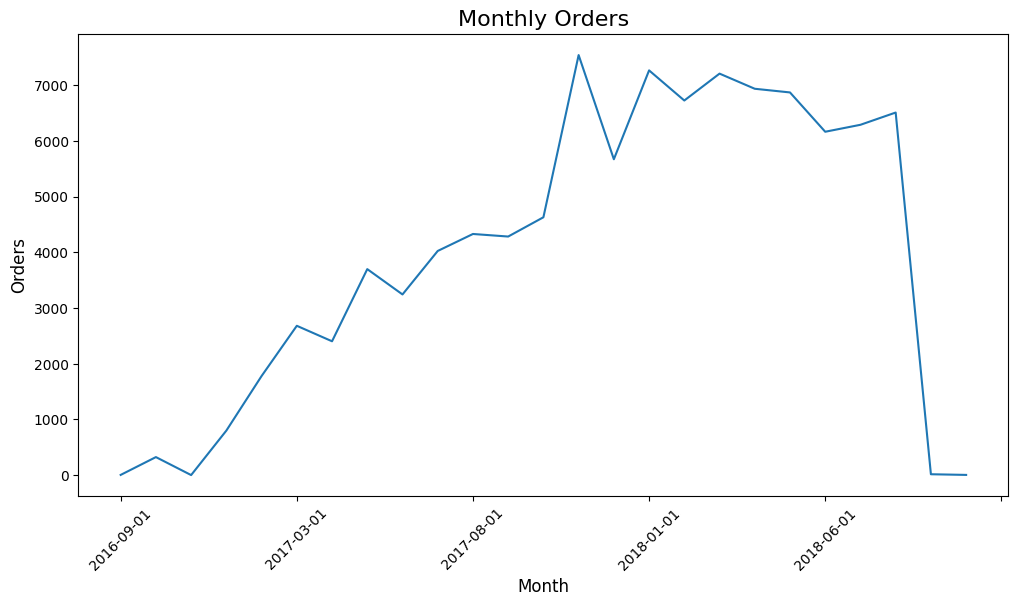

In [24]:
import matplotlib.pyplot as plt


monthly = run_sql("""
SELECT 
  DATE(o.order_purchase_timestamp, 'start of month') AS month,
  COUNT(DISTINCT o.order_id) AS orders
FROM orders o
GROUP BY month
ORDER BY month;
""")

plt.figure(figsize=(12,6))  # leveys=12, korkeus=6 tuumaa
ax = plt.gca()
monthly.plot(x="month", y="orders", kind="line", legend=False, rot=45, ax=ax)

ax.set_title("Monthly Orders", fontsize=16)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Orders", fontsize=12)
plt.show()

## 8. Explain Query Plan — Validating Index Usage
To demonstrate that indexes are actually used, we ask SQLite for the query plan.

In [25]:
run_sql("""
EXPLAIN QUERY PLAN
SELECT *
FROM orders
WHERE customer_id = (SELECT customer_id FROM customers LIMIT 1);
""")

,id,parent,notused,detail
0,3,0,0,SEARCH orders USING INDEX idx_orders_customer_...
1,6,0,0,SCALAR SUBQUERY 1
2,14,6,0,SCAN customers


In [26]:
run_sql("""
EXPLAIN QUERY PLAN
SELECT *
FROM order_items
WHERE order_id = (SELECT order_id FROM orders LIMIT 1);
""")

,id,parent,notused,detail
0,3,0,0,SEARCH order_items USING INDEX idx_items_order...
1,6,0,0,SCALAR SUBQUERY 1
2,14,6,0,SCAN orders


In [27]:
run_sql("""
EXPLAIN QUERY PLAN
SELECT *
FROM order_items
WHERE product_id = (SELECT product_id FROM order_items LIMIT 1);
""")

,id,parent,notused,detail
0,3,0,0,SEARCH order_items USING INDEX idx_items_produ...
1,6,0,0,SCALAR SUBQUERY 1
2,14,6,0,SCAN order_items USING COVERING INDEX idx_item...


## 9. Export for BI 
Export key views as CSV files so BI tools can consume a clean, query-ready dataset.

In [36]:
EXPORT_PATH = "../powerbi/"

os.makedirs(EXPORT_PATH, exist_ok=True)

sales_daily   = run_sql("SELECT * FROM v_sales_daily;")
sales_monthly = run_sql("SELECT * FROM v_sales_monthly;")
customer_rev  = run_sql("SELECT * FROM v_customer_revenue;")
top_products  = run_sql("SELECT * FROM v_top_products_per_customer;")
v_fact_sales  = run_sql("SELECT * FROM v_fact_sales;")

# Export views
sales_daily.to_csv(EXPORT_PATH + "v_sales_daily.csv", index=False)
sales_monthly.to_csv(EXPORT_PATH + "v_sales_monthly.csv", index=False)
customer_rev.to_csv(EXPORT_PATH + "v_customer_revenue.csv", index=False)
top_products.to_csv(EXPORT_PATH + "v_top_products_per_customer.csv", index=False)
v_fact_sales.to_csv(EXPORT_PATH + "v_fact_sales.csv", index=False)

print("Exported CSVs:", os.listdir(EXPORT_PATH))

Exported CSVs: ['.gitkeep', 'portfolio_project_olist.pbix', 'v_customer_revenue.csv', 'v_fact_sales.csv', 'v_sales_daily.csv', 'v_sales_monthly.csv', 'v_top_products_per_customer.csv']


## 10. Conclusion

The workflow covered the full process:

- **Data loading and integrity checks** ensured that all records were unique and consistent.  
- **Schema inspection and indexing** verified that the database was optimized for queries.  
- **KPI views** (`v_sales_daily`, `v_sales_monthly`, `v_customer_revenue`, `v_top_products_per_customer`) were created to simplify recurring business questions.  
- **Quality checks** confirmed that there were no broken foreign keys or duplicate rows.  
- **Query plan validation** demonstrated that indexes were actually being used by SQLite.  
- **Export for BI** provided clean, pre-aggregated datasets in CSV format for further visualization in Power BI or Excel.  
